In [3]:
# %run init_notebookspace.py

In [4]:
import numpy as np
import pandas as pd
import scipy.stats as scs
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from src.helpers_plot import get_ndf_plot
from src.utils import run_parallel_wrap
from advanced_econ import *

In [5]:
import os
path = os.path.abspath("C://Users//au782406//Downloads//advanced econ")

## Question 5

In [6]:
T = 5_000
X0 = 0
alpha = .5
mu = 2
sigma = 1

In [7]:
Xt_mu = get_Xt(X0, alpha, mu, sigma, T)
XT_hat = lambda T: 1/T * np.sum(Xt_mu[:T])
XT_hat_std = lambda T: np.std(Xt_mu[:T])

### a)

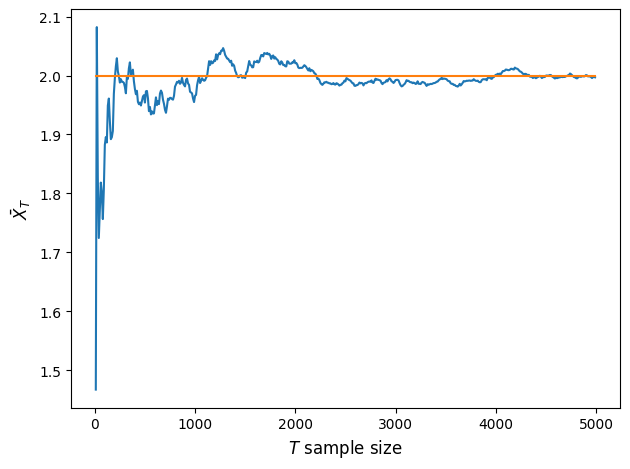

In [5]:
lst_x = range(10, 5_000, 10)
mean = np.array([XT_hat(i) for i in lst_x])
std = np.array([XT_hat_std(i) for i in lst_x])

plt.plot(lst_x, mean)
plt.plot(lst_x, [mu] * len(mean))
plt.ylabel("$\\bar{X}_T$", size=12)
plt.xlabel("$T$ sample size", size=12)
plt.tight_layout()

C:\Users\au782406\Documents\GIT\miscellaneous\advanced_econometrics\src\helpers_plot.py:34: UserWarning: pd.DataFrames are not equivalent
  warnings.warn("pd.DataFrames are not equivalent")


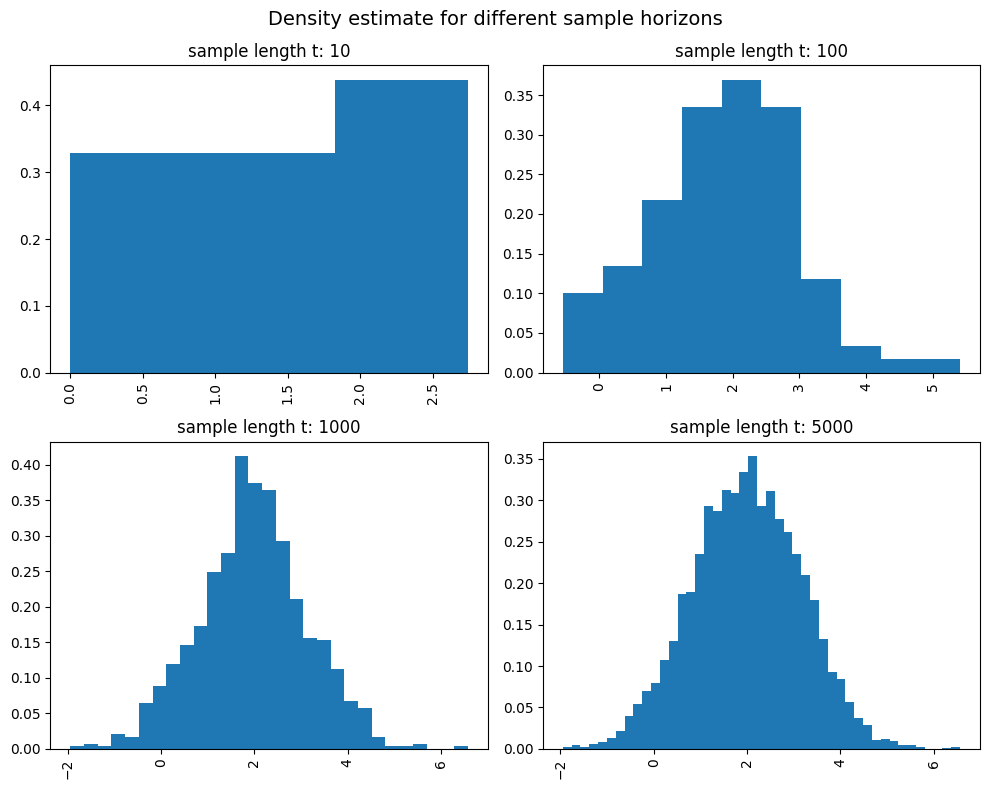

In [6]:
lst = [10, 100, 1000, 5_000]
dct = {f'sample length t: {t}' : pd.DataFrame(Xt_mu[:t], columns=['Xt']) for t in lst}
fig, ax = get_ndf_plot(dct, plot_func=lambda arr, ax: ax.hist(arr, bins='fd', density=True), is_equalise_axis=False, n_cols=2, length_col=5, length_row=4)
fig.suptitle('Density estimate for different sample horizons', size=14)
fig.tight_layout()
fig.savefig(os.path.join(path, "5a.png"))

### b)

In [8]:
M = 10_000
T = 1_000
arr_Xt_montC = np.zeros((M, T))
arr_mu_montC = np.zeros(M)[:,None]

# lst_dct_arguments = [{'X0': X0, 'alpha': alpha, 'mu': scs.norm(mu, 1).rvs(), 'sigma': sigma, 'T': T} for _ in range(M)]
lst_dct_arguments = [{'X0': X0, 'alpha': alpha, 'mu': mu, 'sigma': sigma, 'T': T} for _ in range(M)]
res = run_parallel_wrap(get_monte_carlo_5, lst_dct_arguments, n_process=6)


00%|███████████████████████████████████████████████████████████████████████████████████| 10000/10000 [15:38<00:00, 10.66it/s]

In [12]:
arr_Xt_montC = np.array([i[0] for i in res])
arr_mu_montC = np.array([i[1] for i in res])[:,None]

### d)

estimates for b)

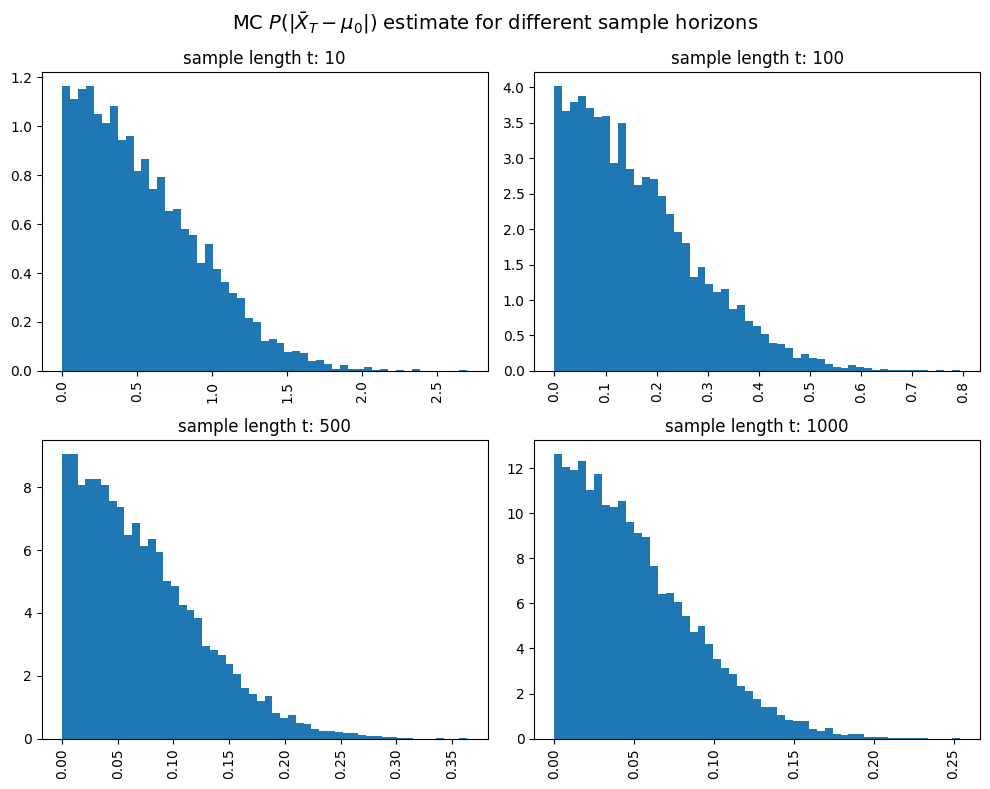

In [59]:
lst = [10, 100, 500, 1000,]
dct = {
    f'sample length t: {t}' : pd.DataFrame(
        np.abs(arr_Xt_montC[:,:t].mean(axis=1)[:,None] - arr_mu_montC),
        columns=['MC t']
    )
    for t in lst
}
fig, ax = get_ndf_plot(dct, plot_func=lambda arr, ax: ax.hist(arr, bins='fd', density=True), is_equalise_axis=False, n_cols=2, length_col=5, length_row=4)
fig.suptitle('MC $P(|\\bar{X}_T - \\mu_0|)$ estimate for different sample horizons', size=14)
fig.tight_layout()
fig.savefig(os.path.join(path, "5d_b.png"))

estimates for c)

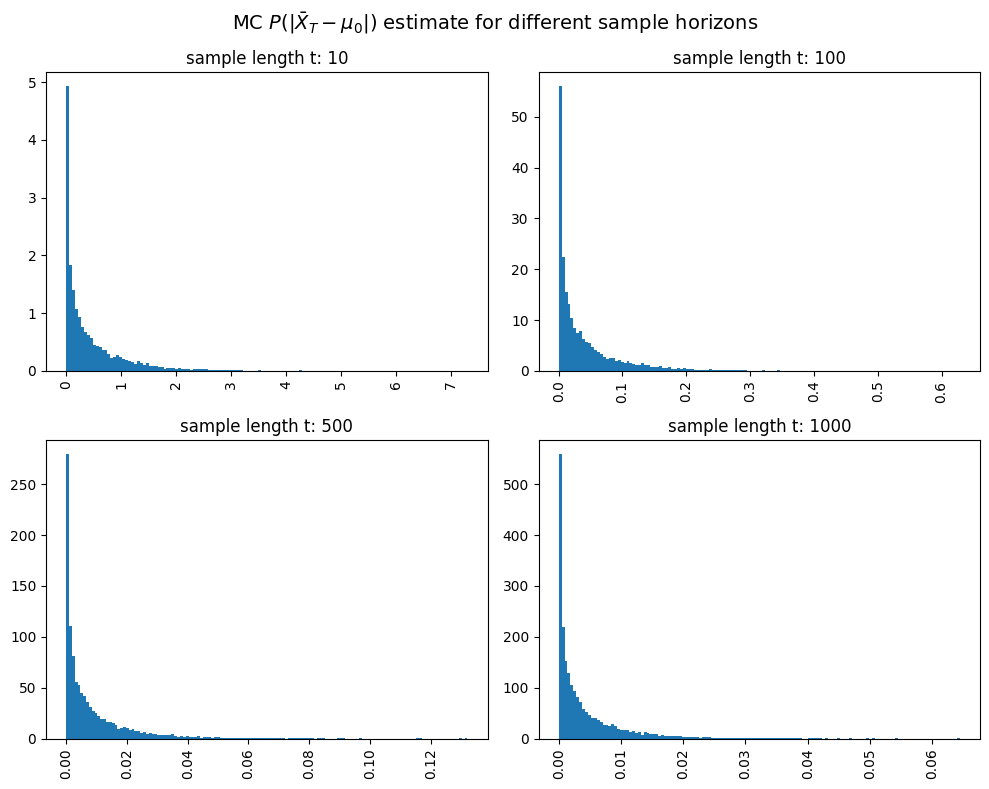

In [60]:
lst = [10, 100, 500, 1000,]
dct = {
    f'sample length t: {t}' : pd.DataFrame(
        (arr_Xt_montC[:,:t].mean(axis=1)[:,None] - arr_mu_montC) ** 2,
        columns=['MC t']
    )
    for t in lst
}
fig, ax = get_ndf_plot(dct, plot_func=lambda arr, ax: ax.hist(arr, bins='fd', density=True), is_equalise_axis=False, n_cols=2, length_col=5, length_row=4)
fig.suptitle('MC $P(|\\bar{X}_T - \\mu_0|)$ estimate for different sample horizons', size=14)
fig.tight_layout()
fig.savefig(os.path.join(path, "5d_c.png"))

## Question 7

In [8]:
alpha_0 = 1/2
power_func = lambda d, alpha : scs.chi2(1).cdf(d**2*(1-alpha**2)**(-1))

### b)

In [9]:
X0 = 0
Xt = get_Xt_7(X0, alpha_0, scs.norm, lst_eps_param=[0,1])

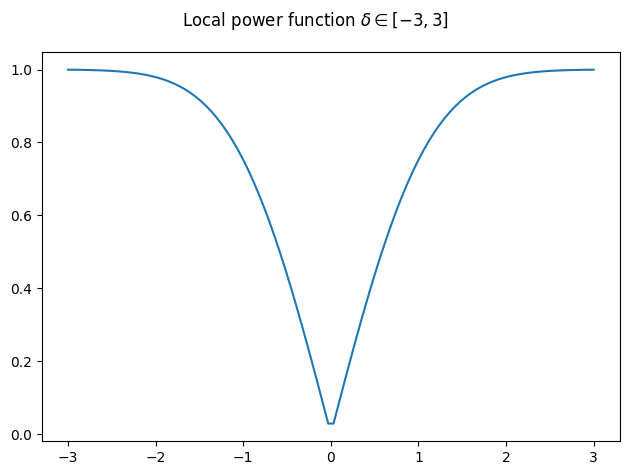

In [35]:
fig, ax = plt.subplots(1,1,)
arr_lspc = np.linspace(-3,3,100)
ax.plot(arr_lspc, [power_func(d, a) for d in arr_lspc], label=f"simulated power")
fig.suptitle("Local power function $\\delta \\in [-3,3]$")
fig.tight_layout()
fig.savefig(os.path.join(path, 'fig7a.png'))

In [36]:
M = 10_00
lst_dct_arguments = [{'X0': X0, 'alpha': alpha_0, 'epsilon_dist': scs.norm, 'lst_eps_param': [0,1], } for _ in range(M)]
res_norm = run_parallel_wrap(get_monte_carlo_7, lst_dct_arguments, n_process=6)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:16<00:00,  7.31it/s]


In [37]:
lst_dct_arguments = [{'X0': X0, 'alpha': alpha_0, 'epsilon_dist': scs.expon, 'lst_eps_param': [1], } for _ in range(M)]
res_exp = run_parallel_wrap(get_monte_carlo_7, lst_dct_arguments, n_process=6)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:27<00:00,  6.79it/s]


In [40]:
d_norm = {i: {k: v[0][1][0] for k,v in val.items() if 'ols' in k} for i, val in enumerate(res_norm)}
d_exp = {i: {k: v[0][1][0] for k,v in val.items() if 'ols' in k} for i, val in enumerate(res_exp)}

In [48]:
d = pd.DataFrame(d_norm).T

In [50]:
c = d['ols10'].apply(lambda x: power_func(x, a) for d in arr_lspc)

,<lambda>,<lambda>,<lambda>,<lambda>,<lambda>,<lambda>,<lambda>,<lambda>,<lambda>,<lambda>,...,<lambda>,<lambda>,<lambda>,<lambda>,<lambda>,<lambda>,<lambda>,<lambda>,<lambda>,<lambda>
0,0.053425,0.053425,0.053425,0.053425,0.053425,0.053425,0.053425,0.053425,0.053425,0.053425,...,0.053425,0.053425,0.053425,0.053425,0.053425,0.053425,0.053425,0.053425,0.053425,0.053425
1,0.072307,0.072307,0.072307,0.072307,0.072307,0.072307,0.072307,0.072307,0.072307,0.072307,...,0.072307,0.072307,0.072307,0.072307,0.072307,0.072307,0.072307,0.072307,0.072307,0.072307
2,0.536863,0.536863,0.536863,0.536863,0.536863,0.536863,0.536863,0.536863,0.536863,0.536863,...,0.536863,0.536863,0.536863,0.536863,0.536863,0.536863,0.536863,0.536863,0.536863,0.536863
3,0.149899,0.149899,0.149899,0.149899,0.149899,0.149899,0.149899,0.149899,0.149899,0.149899,...,0.149899,0.149899,0.149899,0.149899,0.149899,0.149899,0.149899,0.149899,0.149899,0.149899
4,0.467943,0.467943,0.467943,0.467943,0.467943,0.467943,0.467943,0.467943,0.467943,0.467943,...,0.467943,0.467943,0.467943,0.467943,0.467943,0.467943,0.467943,0.467943,0.467943,0.467943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.322865,0.322865,0.322865,0.322865,0.322865,0.322865,0.322865,0.322865,0.322865,0.322865,...,0.322865,0.322865,0.322865,0.322865,0.322865,0.322865,0.322865,0.322865,0.322865,0.322865
996,0.004410,0.004410,0.004410,0.004410,0.004410,0.004410,0.004410,0.004410,0.004410,0.004410,...,0.004410,0.004410,0.004410,0.004410,0.004410,0.004410,0.004410,0.004410,0.004410,0.004410
997,0.099304,0.099304,0.099304,0.099304,0.099304,0.099304,0.099304,0.099304,0.099304,0.099304,...,0.099304,0.099304,0.099304,0.099304,0.099304,0.099304,0.099304,0.099304,0.099304,0.099304
998,0.343297,0.343297,0.343297,0.343297,0.343297,0.343297,0.343297,0.343297,0.343297,0.343297,...,0.343297,0.343297,0.343297,0.343297,0.343297,0.343297,0.343297,0.343297,0.343297,0.343297


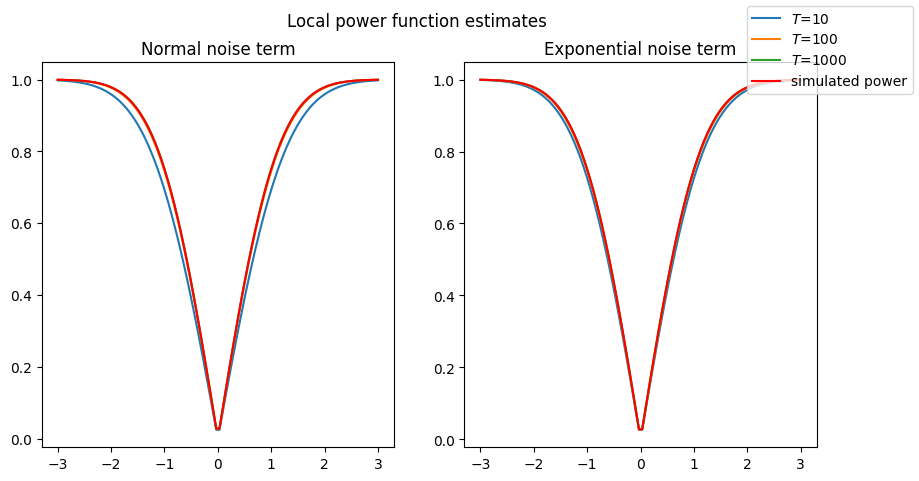

In [41]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
arr_lspc = np.linspace(-3,3,100)
for col, a in pd.DataFrame(d_norm).T.mean(axis=0).items():
    ax[0].plot(arr_lspc, [power_func(d, a) for d in arr_lspc], label=f"$T$={col.split('ols')[-1]}")
for col, a in pd.DataFrame(d_exp).T.mean(axis=0).items():
    ax[1].plot(arr_lspc, [power_func(d, a) for d in arr_lspc],)
    # label=f"$T$={col.split('ols')[-1]}")

ax[0].plot(arr_lspc, [power_func(d, a) for d in arr_lspc], color='red', label=f"simulated power")
ax[1].plot(arr_lspc, [power_func(d, a) for d in arr_lspc], color='red', )

ax[0].set_title('Normal noise term')
ax[1].set_title('Exponential noise term')
fig.legend()
fig.suptitle("Local power function estimates")
fig.savefig(os.path.join(path, 'fig7b.png'))